# Convergence

Description of the UCI protocol: https://ucichessengine.wordpress.com/2011/03/16/description-of-uci-protocol/

Let us parse the logs first:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
! grep "multipv 1" log4.txt  | grep -v lowerbound | grep -v upperbound > log4_g.txt

In [3]:
def parse_info(l):
    D = {}
    k = l.split()
    i = 0
    assert k[i] == "info"
    i += 1
    while i < len(k):
        if k[i] == "depth":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "seldepth":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "multipv":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "score":
            if k[i+1] == "cp":
                D["score_p"] = int(k[i+2]) / 100. # score in pawns
            i += 3
        elif k[i] == "nodes":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "nps":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "hashfull":
            D[k[i]] = int(k[i+1]) / 1000. # between 0 and 1
            i += 2
        elif k[i] == "tbhits":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "time":
            D[k[i]] = int(k[i+1]) / 1000. # elapsed time in [s]
            i += 2
        elif k[i] == "pv":
            D[k[i]] = k[i+1:]
            return D
        else:
            raise Exception("Unknown kw")

In [4]:
# Convert to an array of lists
D = []
for l in open("log4_g.txt").readlines():
    D.append(parse_info(l))

# Convert to a list of arrays
data = {}
for key in D[-1].keys():
    d = []
    for x in D:
        if key in x:
            d.append(x[key])
        else:
            d.append(-1)
    if key != "pv":
        d = array(d)
    data[key] = d

## The Speed of Search

The number of nodes searched depend linearly on time:

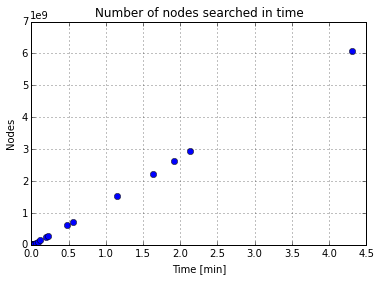

In [5]:
title("Number of nodes searched in time")
plot(data["time"] / 60., data["nodes"], "o")
xlabel("Time [min]")
ylabel("Nodes")
grid()
show()

So nodes per second is roughly constant:

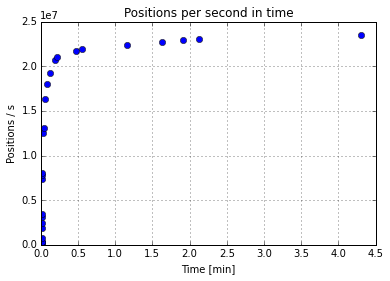

In [6]:
title("Positions per second in time")
plot(data["time"] / 60., data["nps"], "o")
xlabel("Time [min]")
ylabel("Positions / s")
grid()
show()

The hashtable usage is at full capacity:

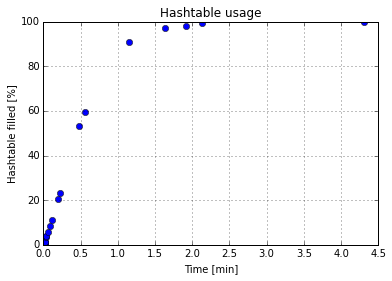

In [7]:
title("Hashtable usage")
hashfull = data["hashfull"]
hashfull[hashfull == -1] = 0
plot(data["time"] / 60., hashfull * 100, "o")
xlabel("Time [min]")
ylabel("Hashtable filled [%]")
grid()
show()

Number of nodes needed for the given depth grows exponentially, except for moves that are forced, which require very little nodes to search (those show as a horizontal plateau):

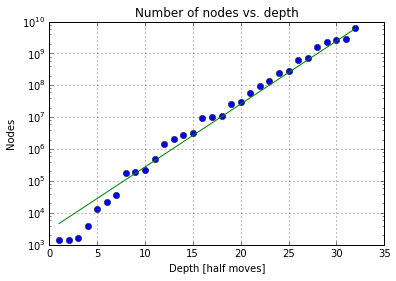

In [8]:
title("Number of nodes vs. depth")
semilogy(data["depth"], data["nodes"], "o")
x = data["depth"]
y = exp(x/2.2)
y = y / y[-1] * data["nodes"][-1]
semilogy(x, y, "-")
xlabel("Depth [half moves]")
ylabel("Nodes")
grid()
show()

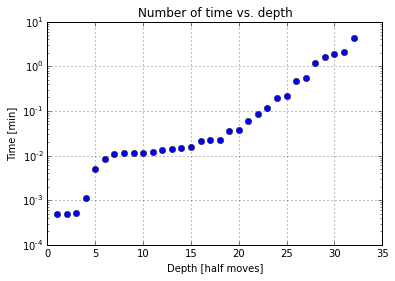

In [9]:
title("Number of time vs. depth")
semilogy(data["depth"], data["time"]/60., "o")
xlabel("Depth [half moves]")
ylabel("Time [min]")
grid()
show()

## Convergence wrt. Depth

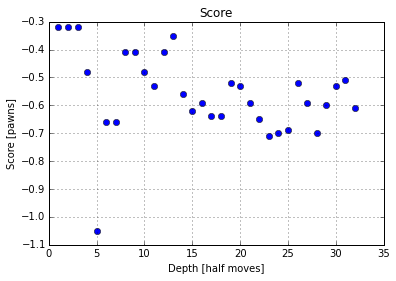

In [10]:
title("Score")
plot(data["depth"], data["score_p"], "o")
xlabel("Depth [half moves]")
ylabel("Score [pawns]")
grid()
show()

Convergence of the variations:

In [11]:
for i in range(len(data["depth"])):
    print "%2i %s" % (data["depth"][i], " ".join(data["pv"][i])[:100])

 1 g1h1
 2 g1h1 h6h5
 3 g1h1 h6h5 f1f4
 4 g1h1 c6e5 f1f4 a7a6
 5 f1f4 c6e5 g1h1 h8h7 a2a3
 6 f1f4 g8g7 d3b5 d8b6 g1h1 c6e5 f4f6 g7f6
 7 g1h1 c6e5 f1f4 g8g7 d3e2 d8d1 a1d1 h8f8
 8 d1f3 d8c7 g1h1 c6e5 f3f4 f6h5 f4h4 e5d3 h4h5
 9 d1f3 d8c7 g1h1 c6e5 f3f4 f6h5 f4h4 e5d3 h4h5 d3e5
10 d1f3 d8c7 g1h1 a8d8 c3e2 c6e5 f3f4 f6h5 f4h4 e5d3
11 d1f3 d8d6 f3f4 d6c5 f4f2 c5f2 f1f2 g8g7 c3b5 a8d8 b5c7 d8d6 c7e6 d6e6
12 d1f3 d8d4 g1h1 d4e5 g2g3 e6h3 g3f4 e5h5 f3h5 f6h5 f1f2 a8f8 a1g1 g8h7 e4e5 h3f5 d3e2 h5g7 e2f3 g7e6 
13 d1f3 d8d4 g1h1 d4e5 g2g3 e6h3 g3f4 e5h5 f3h5 f6h5 f1f2 h8h7 d3c4 g8f8 h1h2 h3d7 c4e2 h5f6 a1g1
14 d1f3 d8d4 g1h1 d4e5 g2g3 e6h3 g3f4 e5h5 f3h5 f6h5 f1g1 g8f8 h1h2 h3e6 a1f1 h8g8 g1g8 e6g8 d3e2 h5f6 
15 d1f3 d8d4 g1h1 d4e5 g2g3 e6h3 g3f4 e5h5 f3h5 f6h5 f1f2 a8f8 a1g1 g8h7 e4e5 h3f5 d3e2 h5g7 e2f3 c6d4 
16 d1f3 d8d4 g1h1 d4e5 g2g3 e6h3 g3f4 e5h5 f3h5 f6h5 f1f2 h8h7 a1g1 h7g7 d3c4 g8h7 g1g7 h5g7 h1h2 h3e6 
17 d1f3 d8d4 g1h1 d4e5 g2g3 e6h3 g3f4 e5h5 f3h5 f6h5 f1f2 h8h7 a1g1 h7g7 g1g7 g8g7 